In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
###################################################################
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


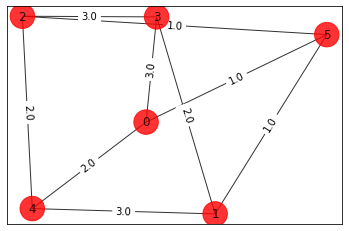

In [2]:

# Generating a graph of 4 nodes

n=6 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,3,3.0),(0,4,2.0),(0,5,1.0),
      (1,3,2.0),(1,4,3.0),(1,5,1.0),
      (2,3,3.0),(2,4,2.0),(2,5,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [3]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 0. 0. 3. 2. 1.]
 [0. 0. 0. 2. 3. 1.]
 [0. 0. 0. 3. 2. 1.]
 [3. 2. 3. 0. 0. 0.]
 [2. 3. 2. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]]


case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 6.0
case = [0, 1, 0, 0, 0, 0] cost = 6.0
case = [1, 1, 0, 0, 0, 0] cost = 12.0
case = [0, 0, 1, 0, 0, 0] cost = 6.0
case = [1, 0, 1, 0, 0, 0] cost = 12.0
case = [0, 1, 1, 0, 0, 0] cost = 12.0
case = [1, 1, 1, 0, 0, 0] cost = 18.0
case = [0, 0, 0, 1, 0, 0] cost = 8.0
case = [1, 0, 0, 1, 0, 0] cost = 8.0
case = [0, 1, 0, 1, 0, 0] cost = 10.0
case = [1, 1, 0, 1, 0, 0] cost = 10.0
case = [0, 0, 1, 1, 0, 0] cost = 8.0
case = [1, 0, 1, 1, 0, 0] cost = 8.0
case = [0, 1, 1, 1, 0, 0] cost = 10.0
case = [1, 1, 1, 1, 0, 0] cost = 10.0
case = [0, 0, 0, 0, 1, 0] cost = 7.0
case = [1, 0, 0, 0, 1, 0] cost = 9.0
case = [0, 1, 0, 0, 1, 0] cost = 7.0
case = [1, 1, 0, 0, 1, 0] cost = 9.0
case = [0, 0, 1, 0, 1, 0] cost = 9.0
case = [1, 0, 1, 0, 1, 0] cost = 11.0
case = [0, 1, 1, 0, 1, 0] cost = 9.0
case = [1, 1, 1, 0, 1, 0] cost = 11.0
case = [0, 0, 0, 1, 1, 0] cost = 15.0
case = [1, 0, 0, 1, 1, 0] cost = 11.0
case = [0, 1, 0, 1, 1, 0] 

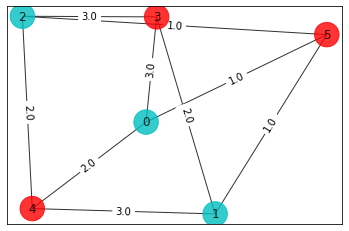

In [4]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

In [5]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

In [6]:
# def XOR(qc, a, b, output):
#     qc.cx(a, output)
#     qc.cx(b, output)
#     clause_list = [[0,1],
#                    [0,2],
#                    [1,3],
#                    [2,3]]
#     i = 0
#     for clause in clause_list:
#         XOR(qc, clause[0], clause[1], clause_qubits[i])
#         i += 1


# def sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits):
#     # Compute clauses
#     i = 0
#     for clause in clause_list:
#         XOR(qc, clause[0], clause[1], clause_qubits[i])
#         i += 1

#     # Flip 'output' bit if all clauses are satisfied
#     qc.mct(clause_qubits, output_qubit)

#     # Uncompute clauses to reset clause-checking bits to 0
#     i = 0
#     for clause in clause_list:
#         XOR(qc, clause[0], clause[1], clause_qubits[i])
#         i += 1

In [7]:
# def row_col_equals_1(qc, clause_list, var_qubits, clause_qubits, cbits):
#     # Compute clauses
#     i = 0
#     for clause in clause_list:
#         XOR(qc, clause[0], clause[1], clause_qubits[i])
#         i += 1

#     # Flip 'output' bit if all clauses are satisfied
#     qc.mct(clause_qubits, output_qubit)

#     # Uncompute clauses to reset clause-checking bits to 0
#     i = 0
#     for clause in clause_list:
#         XOR(qc, clause[0], clause[1], clause_qubits[i])
#         i += 1

In [8]:
# var_qubits = QuantumRegister(4, name='v')
# clause_qubits = QuantumRegister(4, name='c')
# output_qubit = QuantumRegister(1, name='out')
# cbits = ClassicalRegister(4, name='cbits')
# qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# # Initialise 'out0' in state |->
# qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# # Initialise qubits in state |s>
# qc.h(var_qubits)
# qc.barrier()  # for visual separation

# ## First Iteration
# # Apply our oracle
# sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits)
# qc.barrier()  # for visual separation
# # Apply our diffuser
# qc.append(diffuser(4), [0,1,2,3])

# # # ## Second Iteration
# # sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits)
# # qc.barrier()  # for visual separation
# # # Apply our diffuser
# # qc.append(diffuser(4), [0,1,2,3])

# # Measure the variable qubits
# qc.measure(var_qubits, cbits)

# qc.draw()

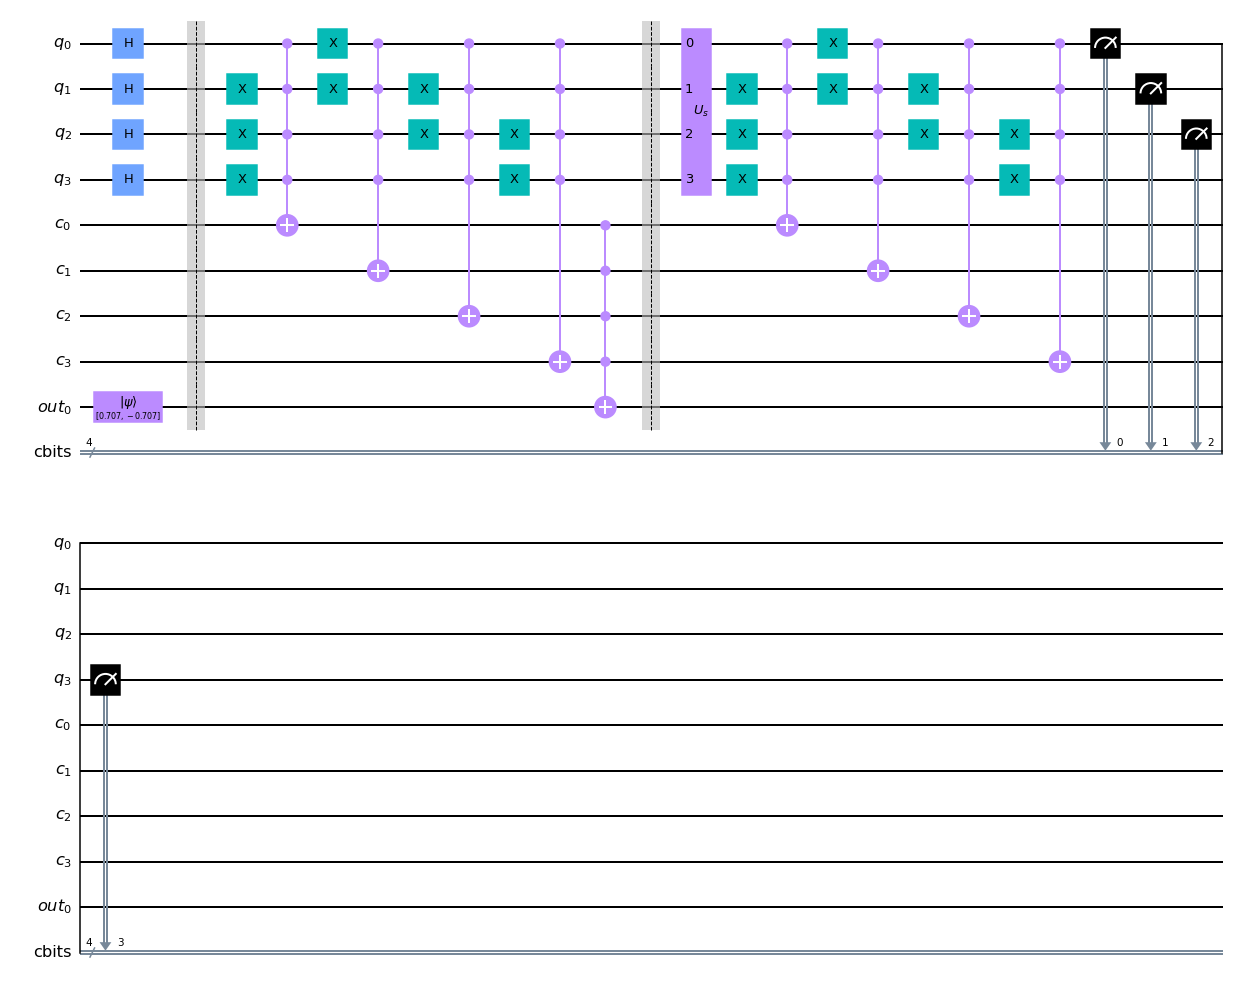

In [9]:
q = QuantumRegister(4,name='q')
cb = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(q, cb, output_qubit, cbits)


qc.h([0,1,2,3])
qc.initialize([1, -1]/np.sqrt(2), [8])
qc.barrier()

qc.x([1,2,3])
qc.mct([0,1,2,3],[4])
qc.x([0,1])
qc.mct([0,1,2,3],[5])
qc.x([1,2])
qc.mct([0,1,2,3],[6])
qc.x([2,3])
qc.mct([0,1,2,3],[7])
qc.mct([4,5,6,7],[8])
qc.barrier()
qc.append(diffuser(4), [0,1,2,3])
qc.x([1,2,3])
qc.mct([0,1,2,3],[4])
qc.x([0,1])
qc.mct([0,1,2,3],[5])
qc.x([1,2])
qc.mct([0,1,2,3],[6])
qc.x([2,3])
qc.mct([0,1,2,3],[7])
qc.measure(q, cbits)
qc.draw()

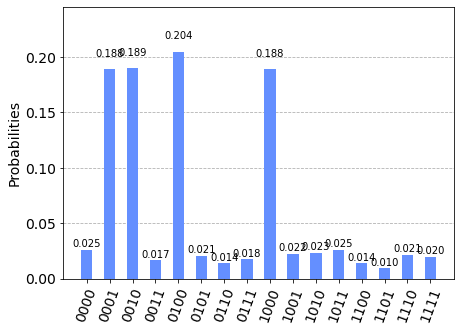

In [10]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend=qasm_simulator, shots=1024).result()
plot_histogram(result.get_counts())

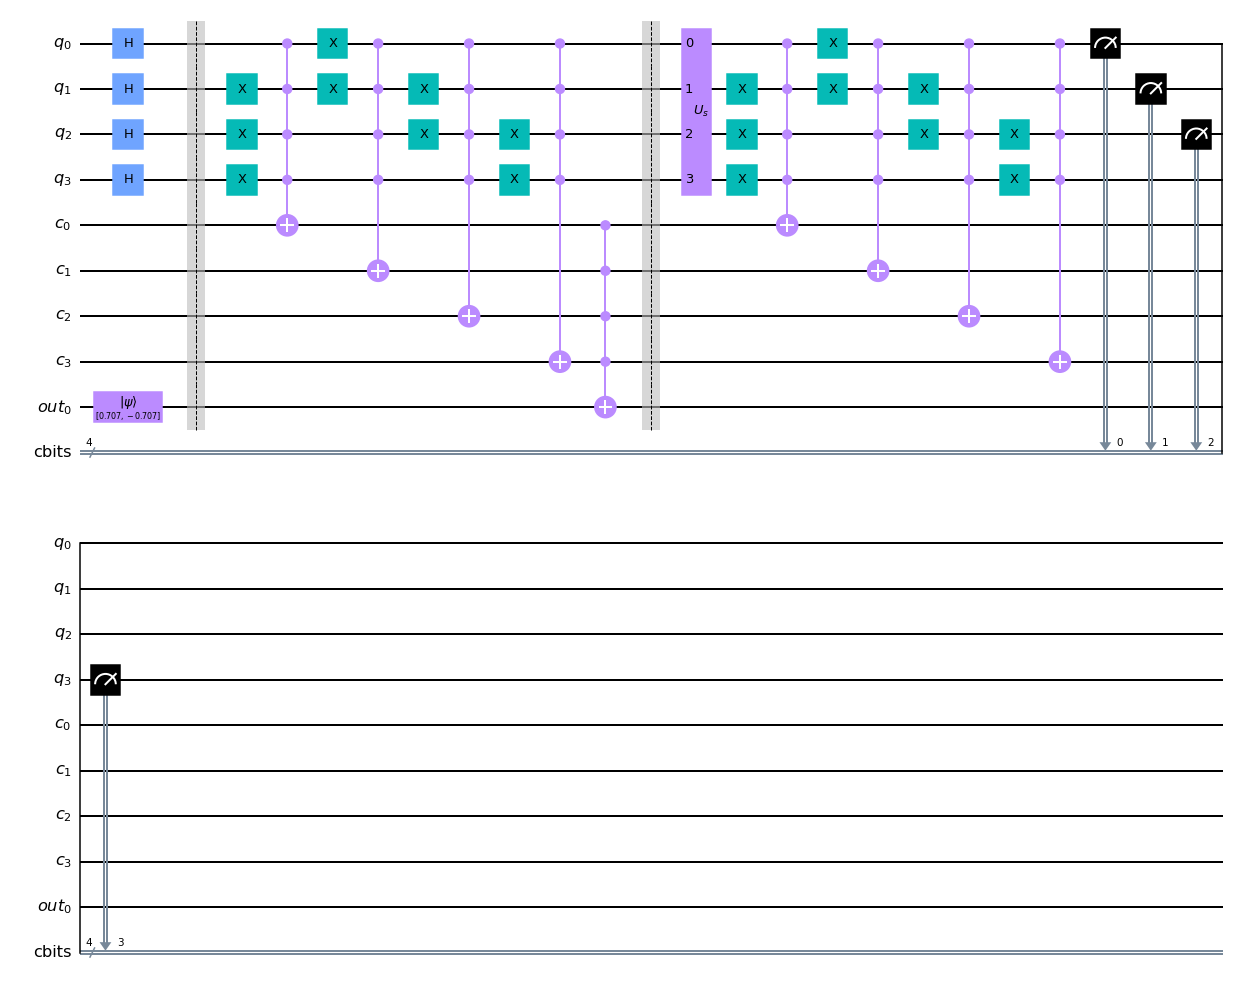

In [11]:
q = QuantumRegister(4,name='q')
cb = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(q, cb, output_qubit, cbits)


qc.h([0,1,2,3])
qc.initialize([1, -1]/np.sqrt(2), [8])
qc.barrier()

qc.x([1,2,3])
qc.mct([0,1,2,3],[4])
qc.x([0,1])
qc.mct([0,1,2,3],[5])
qc.x([1,2])
qc.mct([0,1,2,3],[6])
qc.x([2,3])
qc.mct([0,1,2,3],[7])
qc.mct([4,5,6,7],[8])
qc.barrier()
qc.append(diffuser(4), [0,1,2,3])
qc.x([1,2,3])
qc.mct([0,1,2,3],[4])
qc.x([0,1])
qc.mct([0,1,2,3],[5])
qc.x([1,2])
qc.mct([0,1,2,3],[6])
qc.x([2,3])
qc.mct([0,1,2,3],[7])
qc.measure(q, cbits)
qc.draw()

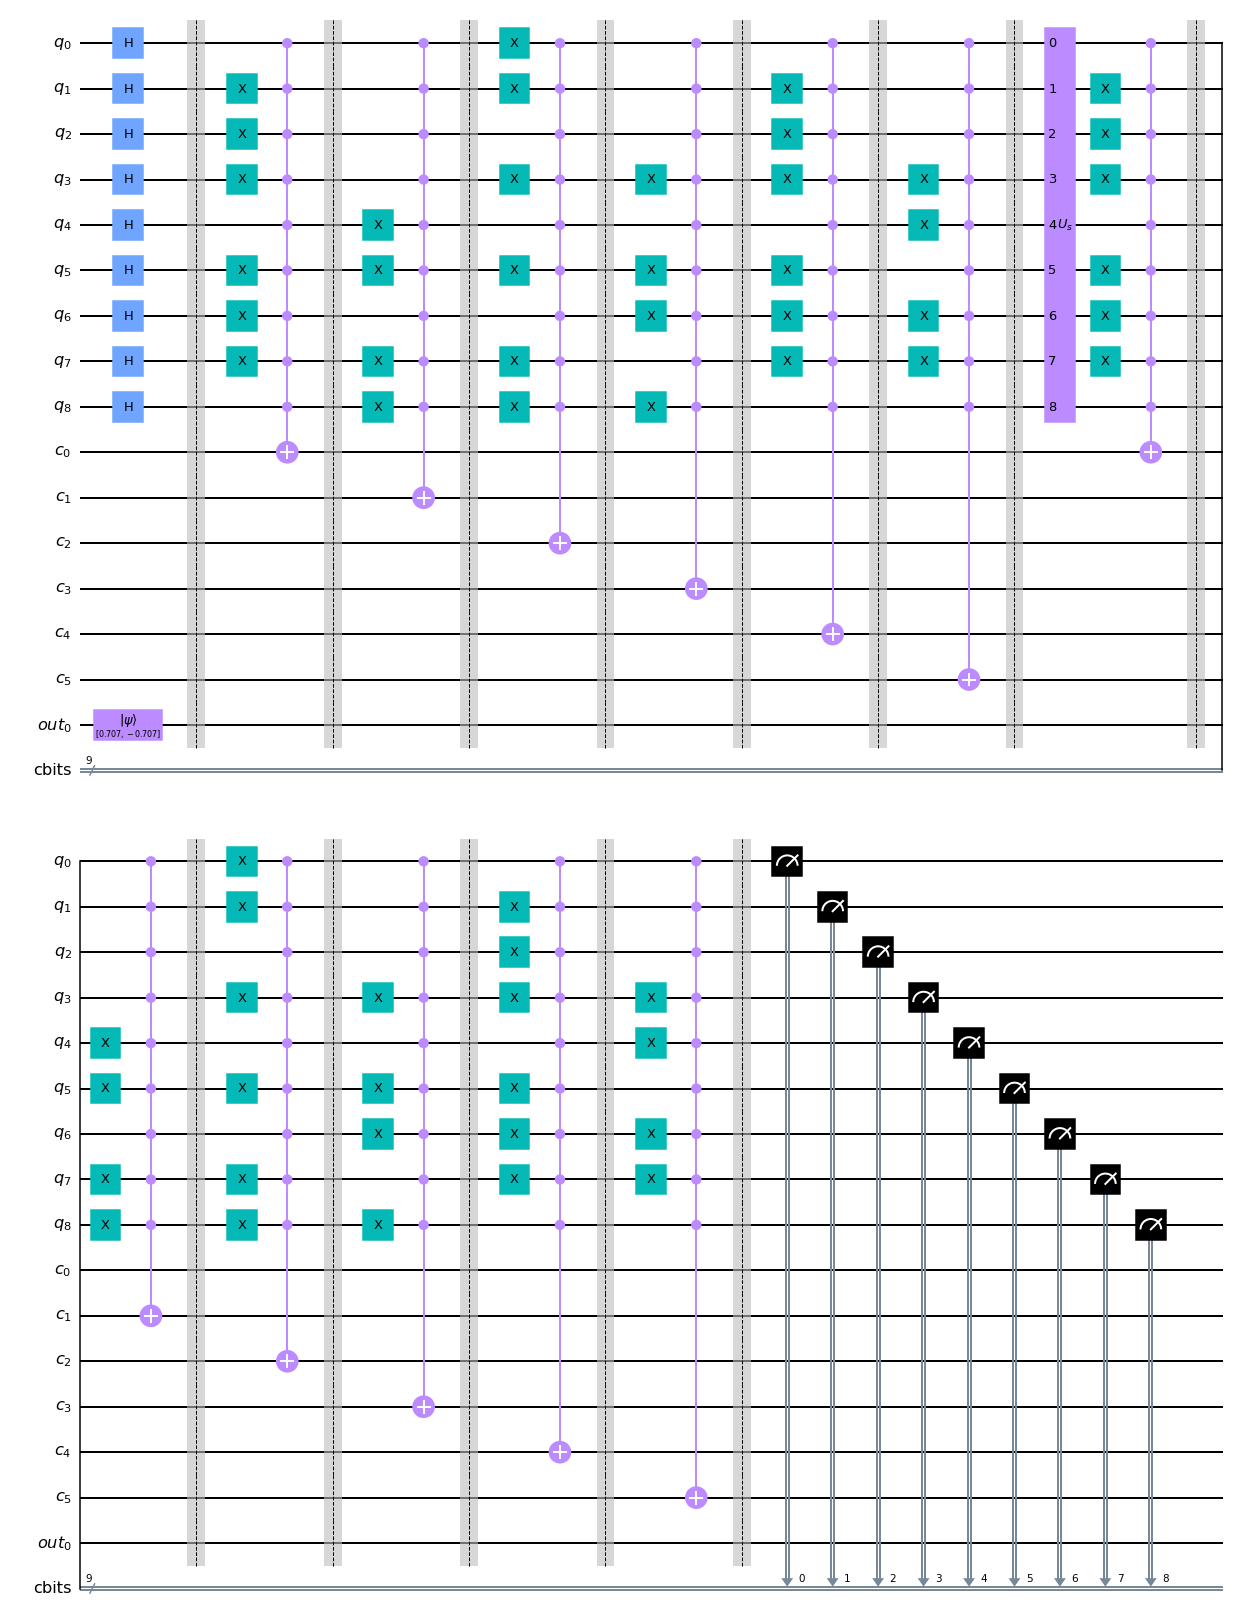

In [152]:
# certo

q = QuantumRegister(9,name='q')
cb = QuantumRegister(6, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(9, name='cbits')
qc = QuantumCircuit(q, cb, output_qubit, cbits)


qc.h([0,1,2,3,4,5,6,7,8])
qc.initialize([1, -1]/np.sqrt(2), [15])
qc.barrier()

qc.x([1,2,3,5,6,7])
qc.mct([0,1,2,3,4,5,6,7,8],[9])
qc.barrier()

qc.x([4,5,7,8])
qc.mct([0,1,2,3,4,5,6,7,8],[10])
qc.barrier()

qc.x([0,1,3,5,7,8])
qc.mct([0,1,2,3,4,5,6,7,8],[11])
qc.barrier()

qc.x([3,5,6,8])
qc.mct([0,1,2,3,4,5,6,7,8],[12])
qc.barrier()

qc.x([1,2,3,5,6,7])
qc.mct([0,1,2,3,4,5,6,7,8],[13])
qc.barrier()

qc.x([3,4,6,7])
qc.mct([0,1,2,3,4,5,6,7,8],[14])
qc.barrier()
qc.append(diffuser(9), [0,1,2,3,4,5,6,7,8])

qc.x([1,2,3,5,6,7])
qc.mct([0,1,2,3,4,5,6,7,8],[9])
qc.barrier()

qc.x([4,5,7,8])
qc.mct([0,1,2,3,4,5,6,7,8],[10])
qc.barrier()

qc.x([0,1,3,5,7,8])
qc.mct([0,1,2,3,4,5,6,7,8],[11])
qc.barrier()

qc.x([3,5,6,8])
qc.mct([0,1,2,3,4,5,6,7,8],[12])
qc.barrier()

qc.x([1,2,3,5,6,7])
qc.mct([0,1,2,3,4,5,6,7,8],[13])
qc.barrier()

qc.x([3,4,6,7])
qc.mct([0,1,2,3,4,5,6,7,8],[14])

qc.barrier()
qc.measure(q, cbits)
qc.draw()

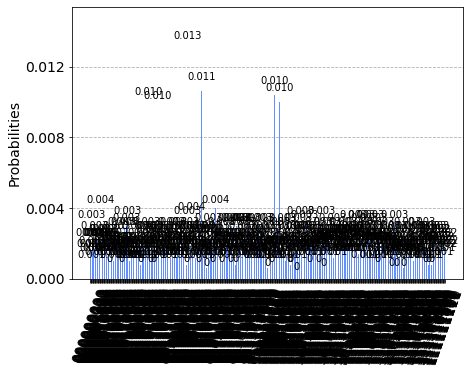

In [45]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend=qasm_simulator, shots=5000).result()
plot_histogram(result.get_counts())

In [46]:
print(result.get_counts())

{'000000000': 11, '000000001': 8, '000010000': 20, '100000000': 3, '100000001': 6, '100000010': 12, '100000011': 5, '100000100': 9, '100000101': 4, '100000110': 9, '100000111': 5, '100001000': 9, '100001001': 8, '100001010': 52, '100001011': 7, '100001100': 7, '100001101': 14, '100001110': 9, '100001111': 6, '000010001': 7, '100010000': 6, '100010001': 50, '100010010': 9, '100010011': 9, '100010100': 9, '100010101': 15, '100010110': 14, '100010111': 11, '100011000': 8, '100011001': 9, '100011010': 5, '100011011': 7, '100011100': 10, '100011101': 10, '100011110': 12, '100011111': 10, '000010010': 12, '100100000': 4, '100100001': 4, '100100010': 13, '100100011': 7, '100100100': 9, '100100101': 10, '100100110': 5, '100100111': 7, '100101000': 13, '100101001': 10, '100101010': 2, '100101011': 11, '100101100': 8, '100101101': 15, '100101110': 13, '100101111': 8, '000010011': 11, '100110000': 17, '100110001': 7, '100110010': 7, '100110011': 13, '100110100': 6, '100110101': 16, '100110110': 9

In [68]:
res = result.get_counts()
valid =  [x for x in res if res[x]>47]
valid

['100001010', '100010001', '001010100', '001100010', '010001100', '010100001']

In [69]:
sorted(res, key=res.get, reverse=True)[:6]

['010001100', '010100001', '100001010', '100010001', '001010100', '001100010']

In [74]:
x=dict.fromkeys((range(5),range(5)),0)
x
# matrix = [0 for _ in range(5)]
# matrix

{range(0, 5): 0}

In [148]:
# número de homens e mulheres n = 2 ou 3

def quantum_marriage(n):
    #matrix = [0 for _ in range(n*n)]
    x_gates = dict.fromkeys(range(n*n),0)
    res = []
    for col in range(n):
        apply_x = []
        for pos in range(col+n,n*n,n):
            # aplicar x caso par
            if x_gates[pos] % 2 == 0:
                apply_x.append(pos)
                x_gates[pos] += 1
            
        for c in range(n):
            if c != col:
                # aplicar x caso par
                if x_gates[c] % 2 == 0:
                    apply_x.append(c)
                    x_gates[c] += 1
            else:
                #aplicar x caso impar
                if x_gates[c] % 2 != 0:
                    apply_x.append(c)
                    x_gates[c] += 1
                    
                
        res.append(apply_x)
    return res

In [153]:
quantum_marriage()

[[4, 8, 12, 1, 2, 3], [5, 9, 13, 0, 1], [6, 10, 14, 1, 2], [7, 11, 15, 2, 3]]